# Inference and Validation

Now that we have a trained network, we can use it for making predictions. However, neural networks have a tendency to perform **overfit** on the training data and aren't able to generalize to data that hasn't been seen before and it impairs inference performance. To test for overfitting while training, we measure the performance on  the **validation** set. We avoid overfitting through regularization such as dropout while monitoring the validation performance during training. In this notebook, I'll show you how to do this in PyTorch. 

Let's start by loading the dataset through torchvision. 

The test set contains images just like the training set. Typically we will see 10-20% of the original dataset held out for testing and validation with the rest being used for training.

In [0]:
import torch
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

0it [00:00, ?it/s]

26427392it [00:01, 13798253.45it/s]                              


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz


0it [00:00, ?it/s]

32768it [00:00, 92383.33it/s]            
0it [00:00, ?it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz


4423680it [00:00, 4429307.58it/s]                            
0it [00:00, ?it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 33082.90it/s]            

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


Here I'll create a model just like the last one

In [0]:
from torch import nn, optim
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

The goal of validation is to measure the model's performance on data that isn't part of the training set. Performance here is typically just accuracy, the percentage of classes the network predicted correctly. We'll focus on accuracy here. First I'll do a forward pass with one batch from the test set.


In [0]:
model = Classifier()

images, labels = next(iter(testloader))
# Get the class probabilities
ps = torch.exp(model(images))
# Make sure the shape is appropriate, we should get 10 class probabilities for 64 examples
print(ps.shape)

torch.Size([64, 10])


With the probabilities, we can get the most likely class using the `ps.topk` method. This returns the $k$ highest values. Since we just want the most likely class, we can use `ps.topk(1)`. This returns a tuple of the top-$k$ values and the top-$k$ indices.

In [0]:
top_p, top_class = ps.topk(1, dim=1)
# Look at the most likely classes for the first 10 examples
print(top_class[:10,:])

tensor([[5],
        [6],
        [5],
        [6],
        [5],
        [5],
        [6],
        [6],
        [5],
        [6]])


Now we can check if the predicted classes match the labels.  we will be comparing one element in each row of `top_class` with each element in `labels` which returns 64 True/False boolean values for each row.

In [0]:
equals = top_class == labels.view(*top_class.shape)

Now we need to calculate the percentage of correct predictions. `equals` has binary values, either 0 or 1. This means that if we just sum up all the values and divide by the number of values, we get the percentage of correct predictions. This is the same operation as taking the mean, so we can get the accuracy with a call to `torch.mean`. 

Now let's train our network and include our validation pass so we can measure how well the network is performing on the test set. Since we're not updating our parameters in the validation pass, we can speed up our code by turning off gradients using `torch.no_grad()`:


 Implementing the validation loop below and printing out the total accuracy after the loop. 

In [0]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 30
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    
    else:
        test_loss = 0
        accuracy=0
        with torch.no_grad():
            for images,labels in testloader:
                log_ps = model(images)
                loss = criterion(log_ps,labels)
                test_loss+= loss.item()
                ps= torch.exp(log_ps)
                top_prob , top_class = ps.topk(1,dim=1)  
                equal = top_class == labels.reshape(top_class.shape)
                accuracy += torch.mean(equal.type(torch.FloatTensor))
        test_losses.append(test_loss/len(testloader))
        train_losses.append(running_loss/len(trainloader))    
        ## Implementing the validation pass and print out the validation accuracy
        print("Epoch{}....".format(e+1, epochs),
              "Training_loss: {:.3f}".format(running_loss/len(trainloader)),
              "Test_loss: {:.3f}".format(test_loss/len(testloader)),
              "Test_Accuracy: {:.3f}".format(accuracy/len(testloader)))



Epoch1.... Training_loss: 0.521 Test_loss: 0.430 Test_Accuracy: 0.849
Epoch2.... Training_loss: 0.392 Test_loss: 0.406 Test_Accuracy: 0.853
Epoch3.... Training_loss: 0.358 Test_loss: 0.405 Test_Accuracy: 0.860
Epoch4.... Training_loss: 0.331 Test_loss: 0.382 Test_Accuracy: 0.866
Epoch5.... Training_loss: 0.317 Test_loss: 0.385 Test_Accuracy: 0.868
Epoch6.... Training_loss: 0.300 Test_loss: 0.370 Test_Accuracy: 0.866
Epoch7.... Training_loss: 0.291 Test_loss: 0.382 Test_Accuracy: 0.869
Epoch8.... Training_loss: 0.282 Test_loss: 0.361 Test_Accuracy: 0.877
Epoch9.... Training_loss: 0.271 Test_loss: 0.372 Test_Accuracy: 0.872
Epoch10.... Training_loss: 0.266 Test_loss: 0.390 Test_Accuracy: 0.873
Epoch11.... Training_loss: 0.258 Test_loss: 0.370 Test_Accuracy: 0.877
Epoch12.... Training_loss: 0.248 Test_loss: 0.356 Test_Accuracy: 0.879
Epoch13.... Training_loss: 0.247 Test_loss: 0.357 Test_Accuracy: 0.877
Epoch14.... Training_loss: 0.240 Test_loss: 0.381 Test_Accuracy: 0.875
Epoch15.... Tra

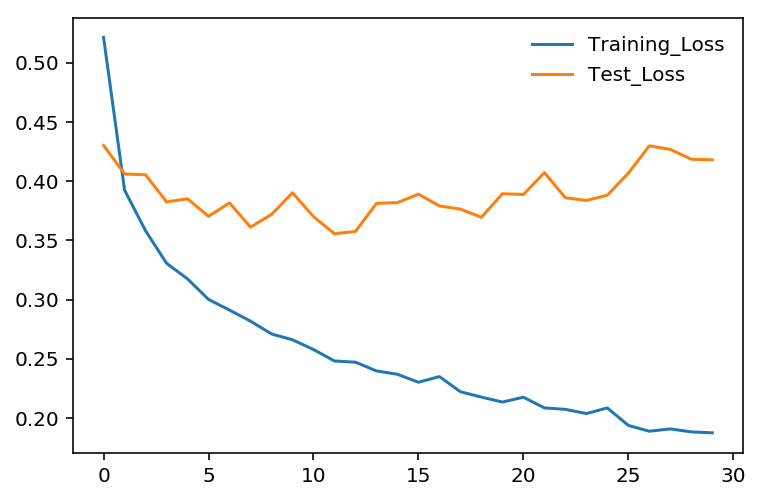

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format= 'retina'
plt.plot(train_losses, label="Training_Loss")
plt.plot(test_losses, label="Test_Loss")
plt.legend(frameon=False)

## Overfitting

If we look at the training and validation losses as we train the network, we can see the overfitting.

Adding dropout to the model and training it on Fashion-MNIST again. See if we can get a lower validation loss or higher accuracy.

In [0]:
## Defining our model with dropout added
from torch import nn, optim
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        self.dropout= nn.Dropout(0.2)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

In [0]:
## Training our model with dropout, and monitoring the training progress with the validation loss and accuracy
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 30
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    model.train()
    for images, labels in trainloader:
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    
    else:
        test_loss = 0
        accuracy=0
        with torch.no_grad():
            model.eval()
            for images,labels in testloader:
                log_ps = model(images)
                loss = criterion(log_ps,labels)
                test_loss+= loss.item()
                ps= torch.exp(log_ps)
                top_prob , top_class = ps.topk(1,dim=1)  
                equal = top_class == labels.reshape(top_class.shape)
                accuracy += torch.mean(equal.type(torch.FloatTensor))
        
        test_losses.append(test_loss/len(testloader))
        train_losses.append(running_loss/len(trainloader))    
        ## Implementing the validation pass and print out the validation accuracy
        print("Epoch{}".format(e+1),
              "Training_loss: {:.3f}".format(running_loss/len(trainloader)),
              "Test_loss: {:.3f}".format(test_loss/len(testloader)),
              "Test_Accuracy: {:.3f}".format(accuracy/len(testloader)))



Epoch1 Training_loss: 0.595 Test_loss: 0.493 Test_Accuracy: 0.825
Epoch2 Training_loss: 0.481 Test_loss: 0.450 Test_Accuracy: 0.839
Epoch3 Training_loss: 0.446 Test_loss: 0.426 Test_Accuracy: 0.846
Epoch4 Training_loss: 0.434 Test_loss: 0.394 Test_Accuracy: 0.856
Epoch5 Training_loss: 0.423 Test_loss: 0.414 Test_Accuracy: 0.851
Epoch6 Training_loss: 0.413 Test_loss: 0.425 Test_Accuracy: 0.853
Epoch7 Training_loss: 0.403 Test_loss: 0.382 Test_Accuracy: 0.865
Epoch8 Training_loss: 0.397 Test_loss: 0.398 Test_Accuracy: 0.860
Epoch9 Training_loss: 0.392 Test_loss: 0.388 Test_Accuracy: 0.864
Epoch10 Training_loss: 0.390 Test_loss: 0.376 Test_Accuracy: 0.866
Epoch11 Training_loss: 0.389 Test_loss: 0.390 Test_Accuracy: 0.865
Epoch12 Training_loss: 0.377 Test_loss: 0.380 Test_Accuracy: 0.869
Epoch13 Training_loss: 0.377 Test_loss: 0.367 Test_Accuracy: 0.874
Epoch14 Training_loss: 0.375 Test_loss: 0.413 Test_Accuracy: 0.865
Epoch15 Training_loss: 0.372 Test_loss: 0.390 Test_Accuracy: 0.867
Epoc

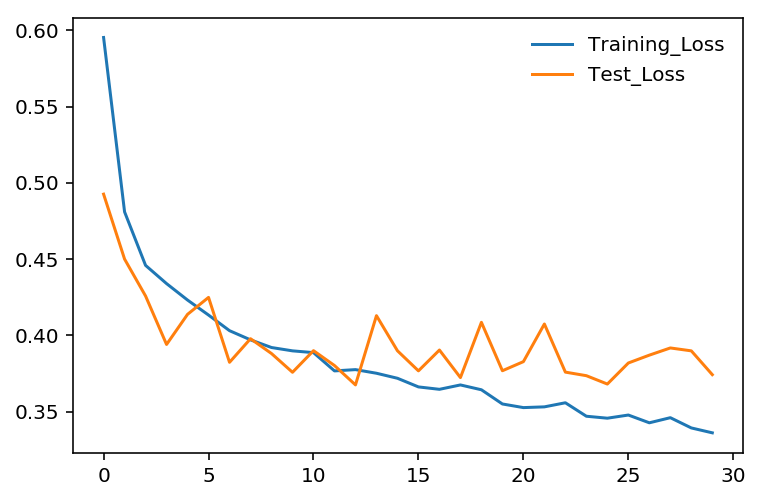

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format= 'retina'
plt.plot(train_losses, label="Training_Loss")
plt.plot(test_losses, label="Test_Loss")
plt.legend(frameon=False)

## Inference

Now that the model is trained, we can use it for inference. We've done this before, but now we need to remember to set the model in inference mode with `model.eval()`.

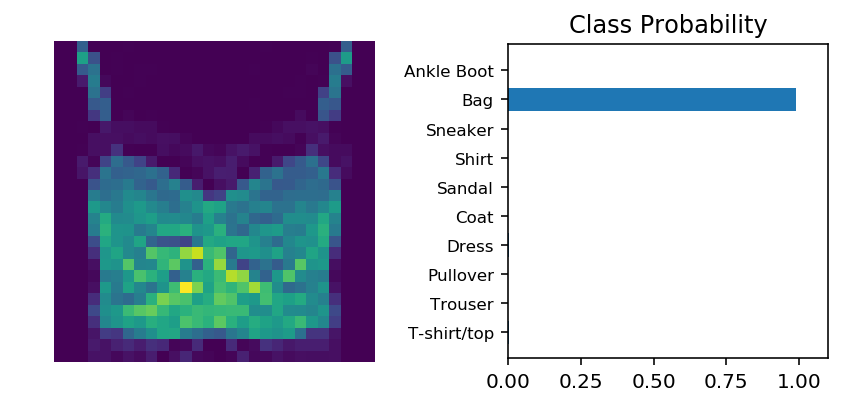

In [0]:
# Import helper module (should be in the repo)
import helper

# Testing out your network!

model.eval()

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]
# Converting 2D image to 1D vector
img = img.view(1, 784)

# Calculating the class probabilities (softmax) for img
with torch.no_grad():
    output = model.forward(img)

ps = torch.exp(output)

# Ploting the image and probabilities
helper.view_classify(img.view(1, 28, 28), ps, version='Fashion')